In [24]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch

from transformations.transform import WaveformToInput as TorchTransform
from architecture.backend.yamnet.params import YAMNetParams
from architecture.backend.yamnet.model import yamnet
from architecture.backend.yamnet.model import yamnet_category_metadata

from architecture.classifier.classification import Classifier

from datasets.SvdExDataset import SvdCutOffShort
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def sf_load_from_int16(fname):
    x, sr = sf.read(fname, dtype='int16', always_2d=True)
    x = x / 2 ** 15
    x = x.T.astype(np.float32)
    return x, sr


waveforms, sr = sf_load_from_int16('2396-i_h.wav')
# waveforms = np.concatenate((waveforms,waveforms),axis=1)
waveform = waveforms[0]
waveform_for_torch = torch.tensor(waveforms)
patches, spectrogram = TorchTransform().wavform_to_log_mel(waveform_for_torch, 50000)
patches.shape




torch.Size([1, 1, 48, 64])

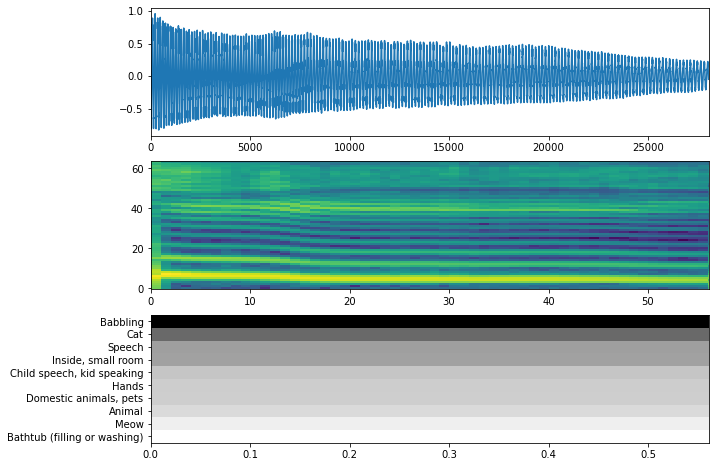

In [3]:

pt_model = yamnet(pretrained=True)
with torch.no_grad():
    pt_model.eval()
    # x = torch.from_numpy(patches)
    # x = x.unsqueeze(1)  # [5, 96, 64] -> [5, 1, 96, 64]
    x = patches
    pt_pred = pt_model(x, to_prob=True)
    pt_pred = pt_pred.numpy()

scores = pt_pred
params = YAMNetParams()
class_names = [x['name'] for x in yamnet_category_metadata()]

# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
extent = (0, spectrogram.shape[0], -0.5, spectrogram.shape[1] - 0.5)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='lower', extent=extent)
plt.xlim([0, len(waveform) / sr / YAMNetParams.STFT_HOP_SECONDS])

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]

plt.subplot(3, 1, 3)
scores_top_class = scores[:, top_class_indices].T
# https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html
extent = (0, scores_top_class.shape[1] * YAMNetParams.PATCH_HOP_SECONDS, scores_top_class.shape[0] - 0.5, -0.5)
plt.imshow(scores_top_class, aspect='auto', interpolation='nearest', cmap='gray_r', extent=extent)
# TODO Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
# patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
# plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
plt.xlim([0, len(waveform) / sr])

# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))
plt.show()




In [29]:
from tqdm import tqdm
from torch.utils.data import DataLoader

dataset = SvdCutOffShort(r"/Users/yiftachedelstain/Development/VoiceDisorderIdentification/data",classification_binary=True)
loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

pt_model = Classifier([512,64])


for idx,x in enumerate(tqdm(loader)):
    with torch.no_grad():
        pt_model.eval()
        # x = torch.from_numpy(patches)
        # x = x.unsqueeze(1)  # [5, 96, 64] -> [5, 1, 96, 64]
        pt_pred = pt_model(x['data'])
        print(pt_pred.shape)
        # print(x['classification'])
        # assert(x['classification'].all())
        # print(pt_pred.shape)

  1%|          | 1/118 [00:02<05:20,  2.74s/it]

torch.Size([128, 10])


  2%|▏         | 2/118 [00:03<03:19,  1.72s/it]

torch.Size([128, 10])


  3%|▎         | 3/118 [00:04<02:38,  1.38s/it]

torch.Size([128, 10])


  3%|▎         | 3/118 [00:05<03:25,  1.79s/it]


KeyboardInterrupt: 